In [1]:
%cd ..

c:\Users\nick\Desktop\HSE\DatingGNN


In [2]:
import re
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from utils.parse_dataset import parse_dataset

In [3]:
df = parse_dataset()

In [4]:
# Convert inches to cm
df["height"] = df["height"].apply(lambda x: round(x * 2.54, 0))

**Missing Values**

In [5]:
mask = df["height"].mean()
df.loc[mask, "height"] = df["height"].median()

In [6]:
df.loc[df.income == -1, "income"] = np.nan

In [7]:
print(f"People that do not declare income: {df.income.isna().sum() / len(df):0.0%}")

People that do not declare income: 81%


In [8]:
isna_cols = df.loc[:, df.isna().any()].columns
missing_values = df[isna_cols[:12]].isna().sum().sort_values(ascending=False)

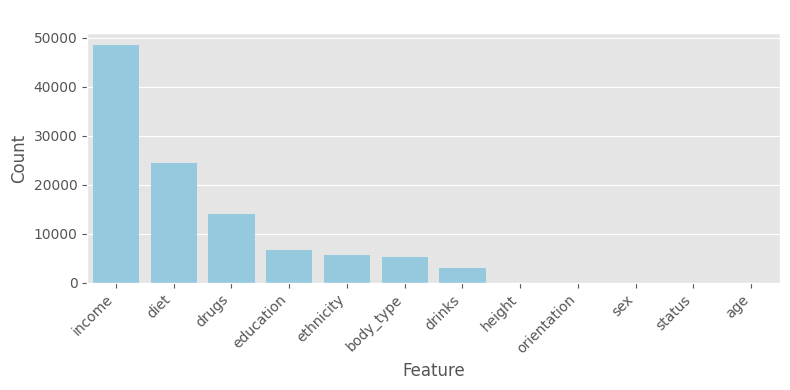

In [9]:
# Visualizing Missing Values Per Feature
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=missing_values.index, y=missing_values, color="skyblue", ax=ax)
ax.set(
    xticks=range(len(missing_values)),
    xticklabels=missing_values.index,  # Rotate labels inside set
    title="Missing values per feature (excluding essays)",
    ylabel="Count",
    xlabel="Feature"
)
plt.xticks(rotation=45, ha="right")
fig.tight_layout()
plt.show()

<Axes: xlabel='orientation', ylabel='count'>

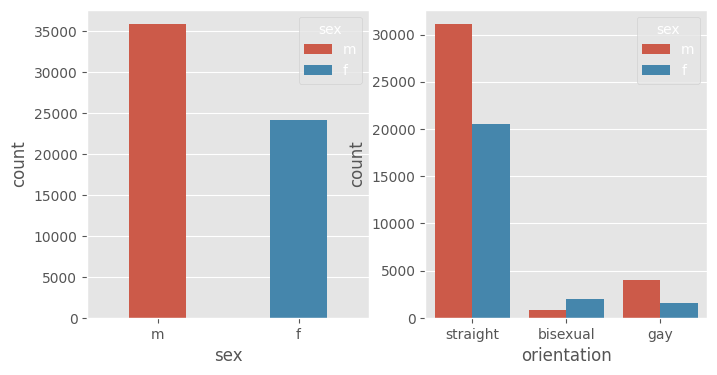

In [10]:
# Sex distribution, Orientation

fig1, ax1 = plt.subplots(ncols=2, figsize=(8, 4))
cat_cols = ["sex", "orientation"]
titles = ["Sex distribution", "Sexual orientation"]

sns.countplot(data=df, x="sex", ax=ax1[0], width=0.4, hue="sex")
sns.countplot(data=df, x="orientation", hue="sex", ax=ax1[1])

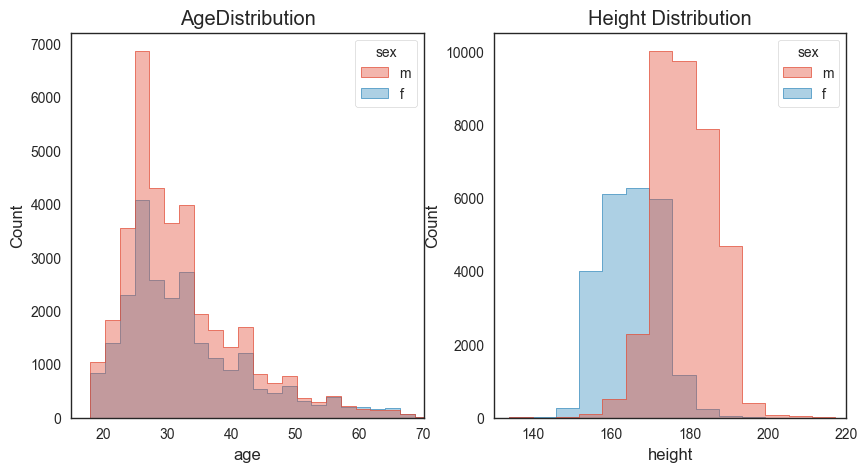

In [11]:
# Age, Height
df["age"] = df["age"].fillna(df["age"].mean())
df["height"] = df["height"].fillna(df["height"].mean())

sns.set_style("white")
num_cols = ["age", "height"]
xlims = [(15, 70), (130, 220)]
titles = ["AgeDistribution", "Height Distribution"]
fig2, ax2 = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
for i, col in enumerate(num_cols):
    sns.histplot(
        data=df, x=col, ax=ax2[i], hue="sex", element="step", bins=40, alpha=0.4
    )
    ax2[i].set(xlim=xlims[i], title=titles[i])

In [12]:
# Location
df[["city_", "state_"]] = df.location.str.split(pat=", ", expand=True).loc[:, 0:1]
df.loc[:, ["location", "city_", "state_"]]
df.state_.value_counts(normalize=True).round(4)[:5] * 100

state_
california       99.85
new york          0.03
illinois          0.01
massachusetts     0.01
oregon            0.01
Name: proportion, dtype: float64

In [13]:
city_count = df.city_.value_counts(normalize=True).round(3)[:20] * 100
city_count.head(3)

city_
san francisco    51.8
oakland          12.0
berkeley          7.0
Name: proportion, dtype: float64

Almost 100% of users are located in California, and more of 50% in San Francisco


## Mapping categories

As there are columns that have several unique values, with teh function below we can map strings into a selected group of few categories, using an ad-hoc dictionary for each features.

I will use an underscore at the end of each handcrafted feature.

In [14]:
def map_cat(a_string, a_dic):
    """
    a_string: a string we want to map with a_dic
    a_dic: a dictionary whose keys are tuples
    """
    for k in a_dic:
        if a_string in k:
            return a_dic.get(k)
    return np.nan

In [15]:
# Body Type
df.body_type.value_counts(dropna=False)

body_type
average           14652
fit               12711
athletic          11819
NaN                5297
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: count, dtype: int64

Too many body types -> grouping all these body types in three categories

In [16]:
body_types_dic = {
    ("skinny", "used up", "thin"): "ectomorph",
    ("average", "fit", "athletic", "jacked"): "mesomorph",
    ("a little extra", "curvy", "full figured"): "endomorph",
}

body_categories = CategoricalDtype(
    categories=["ectomorph", "mesomorph", "endomorph"], ordered=True
)

df["body_type_"] = df.body_type.apply(map_cat, args=(body_types_dic,)).astype(
    body_categories
)
df.body_type_ = df.body_type_.fillna(
    body_categories.categories[int(np.median(df.body_type_.cat.codes))]
)

In [17]:
education_categories = CategoricalDtype(
    categories=[
        "High school or less",
        "Some college",
        "College or more",
        "Post graduate degree",
    ],
    ordered=True,
)

In [18]:
education_dic = {
    (
        "graduated from high school",
        "dropped out of high school",
        "working on high school",
        "high school",
    ): "High school or less",
    (
        "working on two-year college",
        "dropped out of space camp",
        "two-year college",
        "graduated from two-year college",
        "dropped out of college/university",
        "dropped out of two-year college",
        "dropped out of med school",
        "dropped out of law school",
    ): "Some college",
    (
        "working on college/university",
        "working on space camp",
        "graduated from masters program",
        "graduated from college/university",
        "working on masters program",
        "graduated from space camp",
        "college/university",
        "graduated from law school",
        "working on ph.d program",
        "space camp",
        "graduated from med school",
        "working on med school",
        "masters program",
        "dropped out of ph.d program",
        "law school",
        "dropped out of masters program",
        "working on law school",
        "med school",
    ): "College or more",
    ("graduated from ph.d program", "ph.d program"): "Post graduate degree",
}

In [19]:
df["education_"] = df.education.apply(map_cat, args=(education_dic,)).astype(
    education_categories
)

Let's assign the median value of the category to the missing values of this feature.

In [20]:
df.education_ = df.education_.fillna(
    education_categories.categories[int(np.median(df["education_"].cat.codes))]
).astype(education_categories)

([0, 1, 2, 3],
 [Text(0, 0, 'High school or less'),
  Text(1, 0, 'Some college'),
  Text(2, 0, 'College or more'),
  Text(3, 0, 'Post graduate degree')])

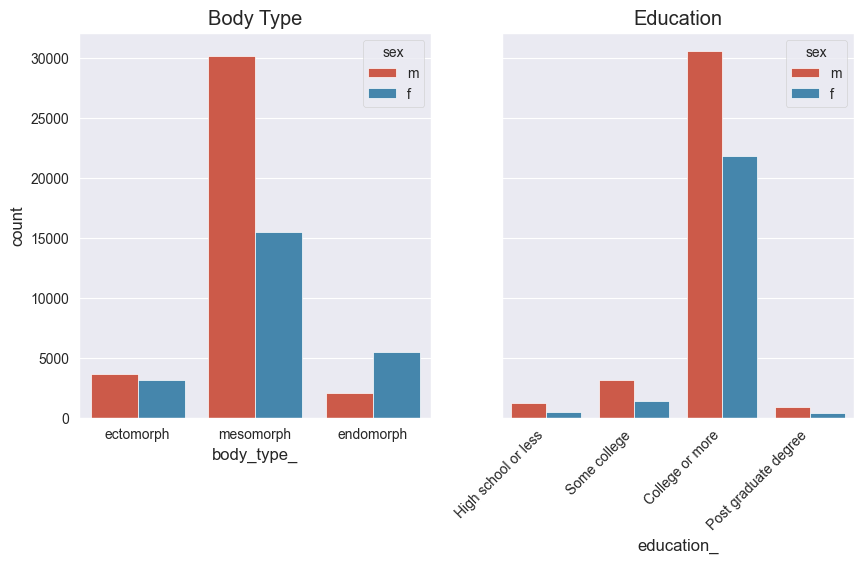

In [21]:
sns.set_style("darkgrid")
cat_cols = ["body_type_", "education_"]
titles = ["Body Type", "Education"]
fig4, ax4 = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=ax4[i], hue="sex")
    ax4[i].set(title=titles[i])
plt.xticks(rotation=45, ha="right")

In [22]:
# Drinks
drinks_categories = CategoricalDtype(
    categories=[
        "not at all",
        "rarely",
        "socially",
        "often",
        "very often",
        "desperately",
    ],
    ordered=True,
)
df["drinks_"] = df.drinks.astype(drinks_categories)
df.drinks_ = df.drinks_.fillna(
    drinks_categories.categories[int(np.median(df.drinks_.cat.codes))]
)

In [23]:
# Drugs
df.drugs.value_counts(dropna=False)

drugs
never        37724
NaN          14081
sometimes     7732
often          410
Name: count, dtype: int64

In this case, 82% of the users declare that they never use drugs. Let's assume that we can fill the missing values with 'never'.

In [24]:
df["drugs_"] = df.drugs.fillna("never")
df.drugs_ = pd.Categorical(
    df.drugs_, categories=["never", "sometimes", "often"], ordered=True
)

In [25]:
df.smokes.value_counts(dropna=False)

smokes
no                43896
NaN                5513
sometimes          3787
when drinking      3040
yes                2231
trying to quit     1480
Name: count, dtype: int64

In [26]:
43896 / len(df)

0.7322468180225866

As 73% of individuals don't smoke. So we will fill the missing values with 'no'.

In [27]:
smokes_dic = {
    ("no",): "no",
    ("sometimes", "when drinking", "trying to quit"): "sometimes",
    ("yes",): "yes",
}
smokes_categories = CategoricalDtype(
    categories=["no", "sometimes", "yes"], ordered=True
)
df["smokes_"] = df.smokes.apply(map_cat, args=(smokes_dic,)).astype(smokes_categories)
df.smokes_ = df.smokes_.fillna("no").astype(smokes_categories)
df.smokes_.value_counts(dropna=False).sort_index()

smokes_
no           49409
sometimes     8307
yes           2231
Name: count, dtype: int64

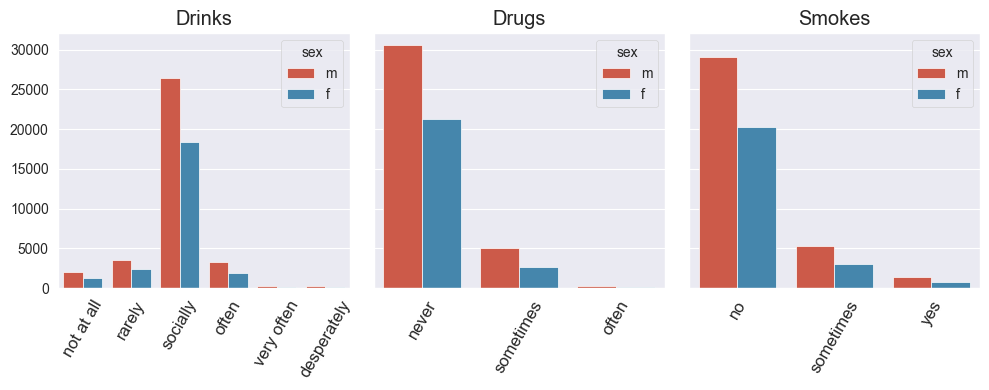

In [28]:
sns.set_style("darkgrid")
cat_cols = ["drinks_", "drugs_", "smokes_"]
titles = ["Drinks", "Drugs", "Smokes"]
xlabels = [
    list(drinks_categories.categories),
    ["never", "sometimes", "often"],
    list(smokes_categories.categories),
]
ticks = [6, 3, 3]
fig5, ax5 = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=ax5[i], hue="sex")
    ax5[i].set(title=titles[i], xticks=range(len(xlabels[i])), xlabel="", ylabel="")
    ax5[i].set_xticklabels(labels=xlabels[i], rotation=60, fontsize=12)
fig5.tight_layout()

In [29]:
# Pets
df.pets.value_counts(dropna=False)

pets
NaN                                19922
likes dogs and likes cats          14814
likes dogs                          7224
likes dogs and has cats             4313
has dogs                            4134
has dogs and likes cats             2333
likes dogs and dislikes cats        2029
has dogs and has cats               1474
has cats                            1406
likes cats                          1063
has dogs and dislikes cats           552
dislikes dogs and likes cats         240
dislikes dogs and dislikes cats      196
dislikes cats                        122
dislikes dogs and has cats            81
dislikes dogs                         44
Name: count, dtype: int64

It makes sense to create two new columns: likes_dogs, likes_cats. we assign 1 if the user has or likes the corresponding kind of pet, and 0 if he does not. Let's assign a 0 in case of missing values (np.nan), in order to be in the safe zone in regards of this feature.

In [30]:
df.pets = df.pets.fillna("No")

In [31]:
def likes_pet(s, species):
    dogs_regex = re.compile(r"((?<!dis)likes |has )dogs")
    cats_regex = re.compile(r"((?<!dis)likes |has )cats")
    if species == "dog":
        return "Yes" if bool(dogs_regex.search(s)) else "No"
    elif species == "cat":
        return "Yes" if bool(cats_regex.search(s)) else "No"
    else:
        return "No"

In [32]:
df["likes_dogs_"] = df.pets.apply(likes_pet, args=("dog",))
df["likes_cats_"] = df.pets.apply(likes_pet, args=("cat",))
df["likes_dogs_"] = pd.Categorical(
    df.likes_dogs_, categories=["No", "Yes"], ordered=True
)
df["likes_cats_"] = pd.Categorical(
    df.likes_cats_, categories=["No", "Yes"], ordered=True
)

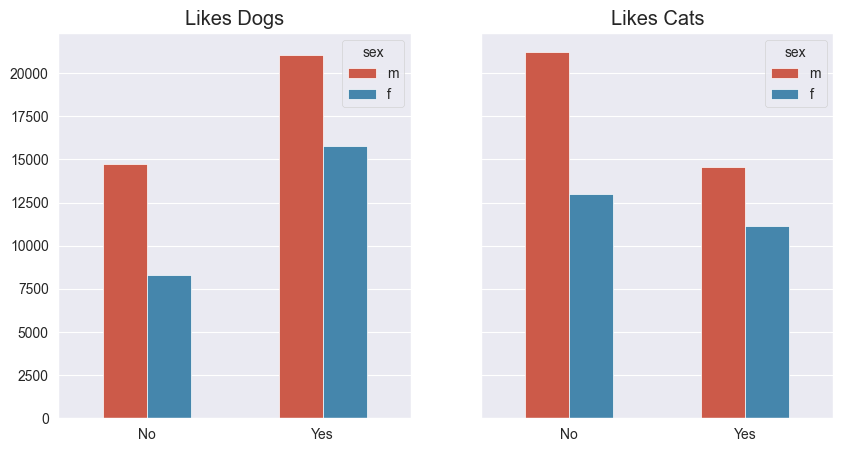

In [33]:
sns.set_style("darkgrid")
cat_cols = ["likes_dogs_", "likes_cats_"]
titles = ["Likes Dogs", "Likes Cats"]
fig6, ax6 = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=ax6[i], hue="sex", width=0.5)
    ax6[i].set(title=titles[i], xlabel="", ylabel="")

**Clustering Users. Unsupervised Learning**

Now we have the features of interest as numerical values. And we can use a clustering algorithm in order to form groups of users with affinity. In this case we are going to apply KMeans, GMM, and DBscan clustering (from scikit-learn)

In [34]:
features = [
    "age",
    "height",
    "body_type_",
    "education_",
    "drinks_",
    "drugs_",
    "smokes_",
    "likes_dogs_",
    "likes_cats_",
]

In [35]:
X = df[features[0:2]].copy()
X.head()

,age,height
0.0,22.0,190.0
1.0,35.0,178.0
2.0,38.0,173.0
3.0,23.0,180.0
4.0,29.0,168.0


Now we transform the categorical data into numerical data, using teh attribute cat.codes of the categorical features.

In [36]:
for feat in features[2:]:
    X[feat] = df[feat].cat.codes

X.isnull().sum()

age            0
height         0
body_type_     0
education_     0
drinks_        0
drugs_         0
smokes_        0
likes_dogs_    0
likes_cats_    0
dtype: int64

In [37]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.set_output(transform="pandas")

X_scaled = scaler.fit_transform(X)

**Inertia**

As per sklearn documentation, inertia is the sum of squared distances of samples to their closest cluster centre.

In [38]:
num_clusters = list(np.arange(1, 21))

inertias = []

for k in num_clusters:
    model = KMeans(n_clusters=k, n_init="auto")
    model.fit(X_scaled)
    inertias.append(model.inertia_)

No we plot the inertias list in order to find the optimal number of clusters. we are using the elbow method: when inertia begins to decrease more slowly.

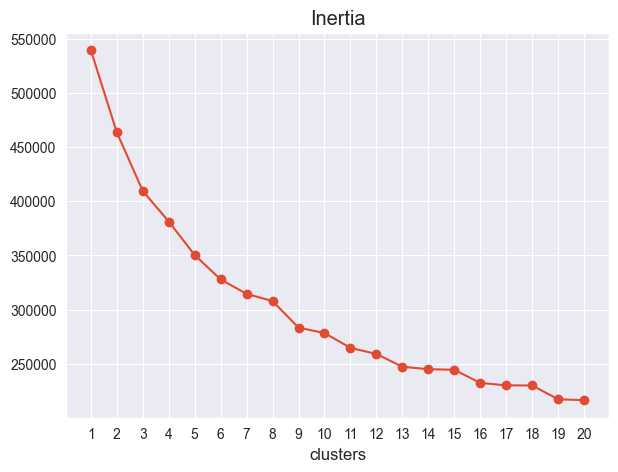

In [39]:
fig7, ax7 = plt.subplots(figsize=(7, 5))

ax7.plot(num_clusters, inertias, "-o")
ax7.set(xticks=num_clusters, xlabel="clusters", title="Inertia");

The choice of the numebr of clusters is always a trade-off to minimise inertia and to keep the numebr of clusters as low as possible. In this case, it makes sense to choose 12 as the number of clusters.

The sklearn algorithm assigns to each point (user) a label, found with the attribute labels_, that we assign to a new columns 'membership' in our dataframe.

In [40]:
k = 12
model = KMeans(n_clusters=k, n_init="auto")
model.fit(X_scaled)
df["membership"] = model.labels_
df.membership.value_counts()

membership
2     10672
1      8756
7      7341
5      5705
10     4284
3      4185
4      4064
0      3712
8      3650
6      3567
9      2496
11     1515
Name: count, dtype: int64

[Text(0.5, 1.0, 'Users per cluster'), Text(0, 0.5, '')]

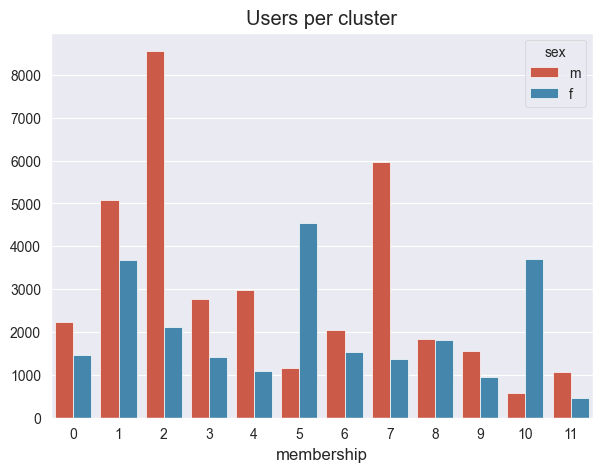

In [41]:
fig8, ax8 = plt.subplots(figsize=(7, 5))

sns.countplot(data=df, x="membership", ax=ax8, hue="sex")
ax8.set(title="Users per cluster", ylabel="")

In [ ]:
from sklearn.cluster import DBSCAN

eps = 0.5
min_samples = 5
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_model.fit(X_scaled)

df["membership"] = dbscan_model.labels_
df.membership.value_counts()

In [43]:
from sklearn.mixture import GaussianMixture

num_clusters = list(np.arange(1, 21))
bics = []

for k in num_clusters:
    gmm_model = GaussianMixture(n_components=k, random_state=42)
    gmm_model.fit(X_scaled)
    bics.append(gmm_model.bic(X_scaled))

optimal_k = num_clusters[np.argmin(bics)]

In [44]:
optimal_k

np.int64(20)

**Lover recommendation: An example**

Features of interest we are considering:

In [45]:
features = [
    "age",
    "height",
    "sex",
    "orientation",
    "body_type_",
    "education_",
    "drinks_",
    "drugs_",
    "smokes_",
    "likes_dogs_",
    "likes_cats_",
    "membership",
]

Let's say that we want to recommend profiles that user_id 42 can be interested in. This user is a male, with sexual orientation 'straight'.

In [46]:
df.loc[42:42, features]

,age,height,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
42.0,30.0,190.0,m,straight,mesomorph,College or more,often,sometimes,no,No,No,19


In [47]:
users = df.loc[
    (df.sex == "f")
    & (df.membership == df.at[42, "membership"])
    & (df.orientation == "straight")
    ].index
print(f"So we have found {len(users)} female users in the same cluster.\n")

So we have found 35 female users in the same cluster.



**Distances**

Now we can prepare an ordered list based on affinity. First of all we need to calculate the distance between user 42 and the rest of profiles we have just found.

In [48]:
def distance(row, user):
    result = 0
    for i, v in enumerate(row):
        result += (v - user[i]) ** 2
    return result ** 0.5;

In [49]:
user = X_scaled.iloc[42]
distances = X_scaled.loc[users].apply(distance, axis=1, args=(user,)).sort_values();

C:\Users\nick\AppData\Local\Temp\ipykernel_20792\1105939345.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result += (v - user[i]) ** 2


In [50]:
df.loc[42:42, features]

,age,height,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
42.0,30.0,190.0,m,straight,mesomorph,College or more,often,sometimes,no,No,No,19


In [51]:
df.loc[distances.index, features].head(3)

,age,height,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
31343.0,25.0,183.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
55767.0,30.0,175.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
13776.0,32.0,175.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19


We can see that the features are pretty similar.

**Affinity**

In [52]:
gamma = 1 / (len(features))

And now we can print the top ten choices for the user 42 with a similarity score:

In [53]:
S = pd.DataFrame(
    distances.apply(lambda x: round(np.exp(-x * gamma) * 100, 1)).rename("affinity")
)
S.rename_axis("user_id", inplace=True)
print("Top 3 users by affinity with user_id = 42")
S.head(3)

Top 3 users by affinity with user_id = 42


,affinity
user_id,
31343.0,93.0
55767.0,88.4
13776.0,88.3
